In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2
import pandas as pd

In [2]:
IMG_SIZE=128
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 128
VOLUME_START_AT = 22 # first slice of volume that we will include

In [3]:
TRAIN_DATASET_PATH = '/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data'


In [4]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [5]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [6]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
  
#Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))


             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
       
        # Generate masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #Y = np.array(Y).reshape(1,128,128,128)
        return X/np.max(X), y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [8]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=5, verbose=1, mode='auto'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,mode='max'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001, verbose=1),
      csv_logger
    ]

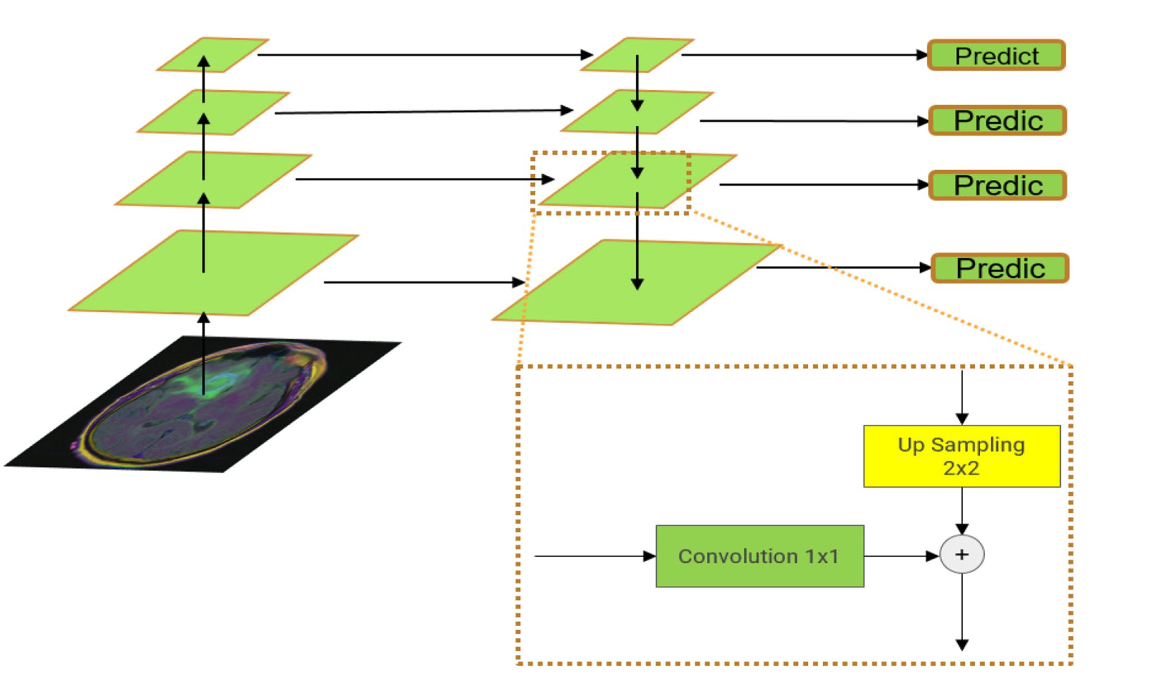

In [9]:
def FPN(input_layer):
    conv1 = Conv2D(256,3, activation = 'relu', padding = 'same',strides=4)(input_layer)
    conv2 = Conv2D(512, 3, activation = 'relu', padding = 'same',strides=8)(conv1)
    conv3 = Conv2D(1024, 3, activation = 'relu', padding = 'same',strides=16)(conv2)
    conv4 = Conv2D(2056, 3, activation = 'relu', padding = 'same',strides=32)(conv3)
    conv5 = Conv2D(256,1, activation = 'relu', padding = 'same')(conv4)
    conv6 = Conv2D(256, 1, activation = 'relu', padding = 'same')(conv3)
    conv7 = Conv2D(256, 1, activation = 'relu', padding = 'same')(conv2)
    conv8 = Conv2D(256, 1, activation = 'relu', padding = 'same')(conv1)
    
    up1 = UpSampling2D(size = (2,2))(conv5)
    b1 = Add()([up1,conv6])
    up2 = UpSampling2D(size = (2,2))(b1)
    b2 = Add()([up2,conv7])
    up3 = UpSampling2D(size = (8,8))(b2)
    b3 = Add()([up3,conv8])

    c1 = Conv2D(128,3, activation = 'relu', padding = 'same')(conv5)
    c1 = Conv2D(128,3, activation = 'relu', padding = 'same')(c1)
    c1 = UpSampling2D(size = (128,128))(c1)

    c2 = Conv2D(128,3, activation = 'relu', padding = 'same')(b1)
    c2 = Conv2D(128,3, activation = 'relu', padding = 'same')(c2)
    c2 = UpSampling2D(size = (64,64))(c2)

    c3 = Conv2D(128,3, activation = 'relu', padding = 'same')(b2)
    c3 = Conv2D(128,3, activation = 'relu', padding = 'same')(c3)
    c3 = UpSampling2D(size = (32,32))(c3)

    c4 = Conv2D(128,3, activation = 'relu', padding = 'same')(b3)
    c4 = Conv2D(128,3, activation = 'relu', padding = 'same')(c4)
    c4 = UpSampling2D(size = (4,4))(c4)

    c5 = tf.keras.layers.concatenate([c1,c2,c3,c4])
    c6 = Conv2D(4, (1,1), activation = 'softmax')(c5)
    return c6
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

In [10]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

In [11]:
output_layer = FPN(input_layer)

In [12]:
model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [13]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic,
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 256)  4864        ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 4, 512)    1180160     ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 1, 1, 1024)   4719616     ['conv2d_1[0][0]']           

In [14]:
history =  model.fit(training_generator,
                     epochs=30,
                     steps_per_epoch= 300,
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )


Epoch 1/30


2023-12-28 17:57:53.765585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-28 17:57:53.786268: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


300/300 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9851 - mean_io_u: 0.3823 - dice_coef: 0.2731 - precision: 0.9811 - sensitivity: 0.9794 - specificity: 0.9959 - dice_coef_necrotic: 0.0520 - dice_coef_edema: 0.1145 - dice_coef_enhancing: 0.0600

2023-12-28 18:25:11.970488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 1934s 6s/step - loss: 0.0844 - accuracy: 0.9851 - mean_io_u: 0.3823 - dice_coef: 0.2731 - precision: 0.9811 - sensitivity: 0.9794 - specificity: 0.9959 - dice_coef_necrotic: 0.0520 - dice_coef_edema: 0.1145 - dice_coef_enhancing: 0.0600 - val_loss: 0.0599 - val_accuracy: 0.9863 - val_mean_io_u: 0.4100 - val_dice_coef: 0.2870 - val_precision: 0.9870 - val_sensitivity: 0.9862 - val_specificity: 0.9957 - val_dice_coef_necrotic: 0.0545 - val_dice_coef_edema: 0.1120 - val_dice_coef_enhancing: 0.0522 - lr: 0.0010
Epoch 2/30
300/300 [==============================] - 1906s 6s/step - loss: 0.0547 - accuracy: 0.9871 - mean_io_u: 0.3994 - dice_coef: 0.2908 - precision: 0.9890 - sensitivity: 0.9846 - specificity: 0.9963 - dice_coef_necrotic: 0.0909 - dice_coef_edema: 0.1692 - dice_coef_enhancing: 0.0840 - val_loss: 0.0564 - val_accuracy: 0.9863 - val_mean_io_u: 0.3768 - val_dice_coef: 0.2856 - val_precision: 0.9863 - val_sensitivity: 0.9863 - val_specifi

Epoch 15/30
300/300 [==============================] - 2015s 7s/step - loss: 0.0300 - accuracy: 0.9905 - mean_io_u: 0.5399 - dice_coef: 0.3976 - precision: 0.9933 - sensitivity: 0.9883 - specificity: 0.9978 - dice_coef_necrotic: 0.1867 - dice_coef_edema: 0.4755 - dice_coef_enhancing: 0.3006 - val_loss: 0.0318 - val_accuracy: 0.9898 - val_mean_io_u: 0.5223 - val_dice_coef: 0.4037 - val_precision: 0.9929 - val_sensitivity: 0.9876 - val_specificity: 0.9976 - val_dice_coef_necrotic: 0.1889 - val_dice_coef_edema: 0.4939 - val_dice_coef_enhancing: 0.3318 - lr: 2.0000e-04
Epoch 16/30
300/300 [==============================] - 1905s 6s/step - loss: 0.0292 - accuracy: 0.9907 - mean_io_u: 0.5615 - dice_coef: 0.4046 - precision: 0.9935 - sensitivity: 0.9886 - specificity: 0.9979 - dice_coef_necrotic: 0.1937 - dice_coef_edema: 0.4775 - dice_coef_enhancing: 0.3269 - val_loss: 0.0316 - val_accuracy: 0.9899 - val_mean_io_u: 0.5705 - val_dice_coef: 0.4069 - val_precision: 0.9930 - val_sensitivity: 0.9

In [15]:
model.save('FPN.h5')

In [35]:
model = keras.models.load_model('/Users/sanjaydilli/FPN/FPN.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)


In [78]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )


In [16]:
history = pd.read_csv('/Users/sanjaydilli/FPN/training.log', sep=',', engine='python')

In [17]:
hist=history

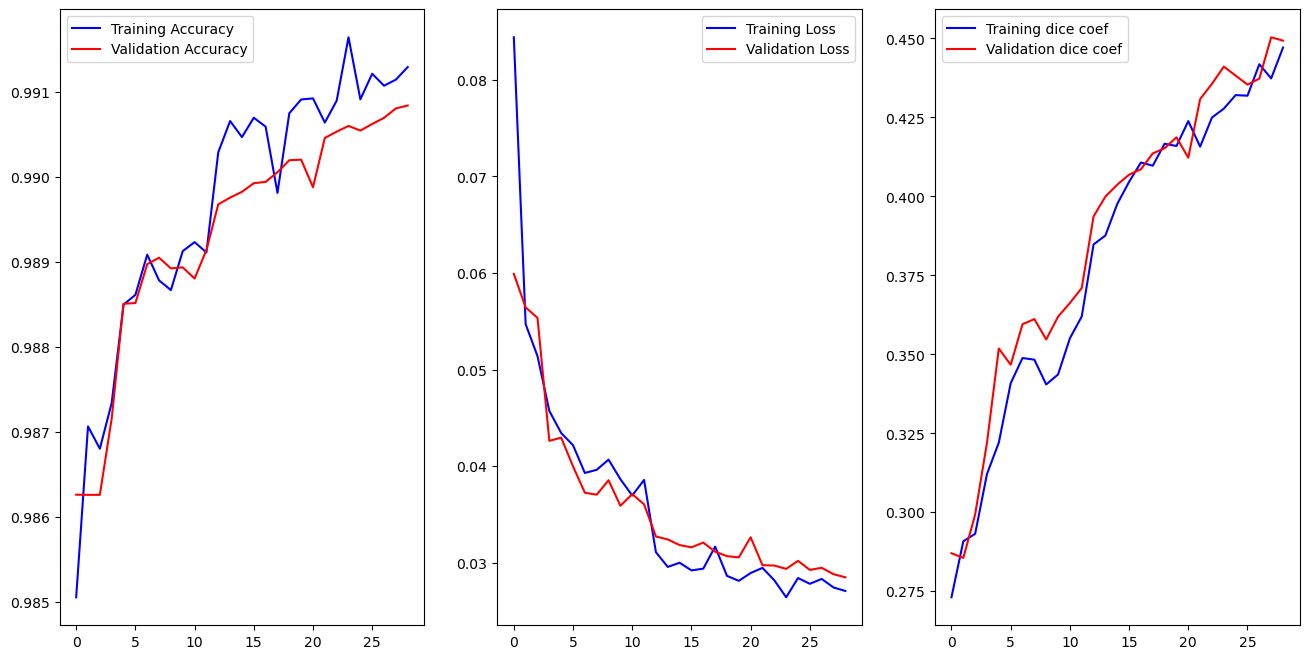

In [18]:
val_acc=hist['val_accuracy']
acc=hist['accuracy']
epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()



plt.show()

In [17]:
print("Evaluate on test data")
results = model.evaluate(test_generator, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


2023-12-15 10:54:47.579510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - 180s 1s/step - loss: 0.0351 - accuracy: 0.9903 - mean_io_u: 0.8086 - dice_coef: 0.3819 - precision: 0.9917 - sensitivity: 0.9894 - specificity: 0.9972 - dice_coef_necrotic: 0.1268 - dice_coef_edema: 0.3611 - dice_coef_enhancing: 0.2562
test loss, test acc: [0.035094212740659714, 0.9903483986854553, 0.8085966110229492, 0.38186946511268616, 0.9916979074478149, 0.989426851272583, 0.9972401857376099, 0.12678155303001404, 0.36114075779914856, 0.2561906576156616]


In [36]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
 
    
    vol_path = os.path.join(case_path, f'BraTS2021{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS2021{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 
    return model.predict(X/np.max(X), verbose=1)


In [42]:
def showPredictsById(case, start_slice = 60):
    path = f"/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data/BraTS2021{case}"
    gt = nib.load(os.path.join(path, f'BraTS2021{case}_seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path,f'BraTS2021{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4])
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:])
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,])
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,])
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    axarr
    plt.show()
    

4/4 [==============================] - 1s 293ms/step


<Figure size 1800x5000 with 0 Axes>

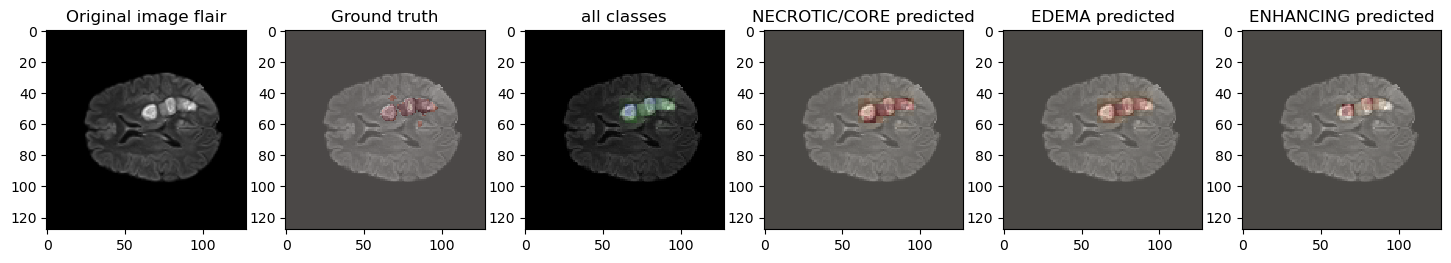

In [46]:
showPredictsById(case=test_ids[4][-6:])


In [19]:
flair =  nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_flair.nii.gz')).get_fdata()

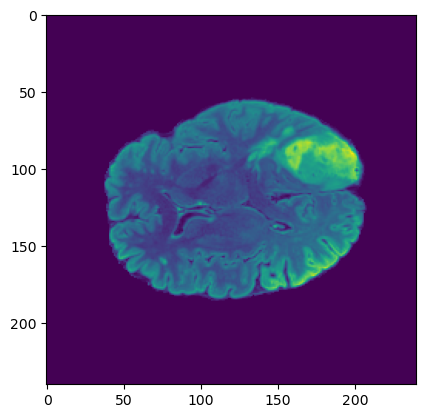

In [56]:
plt.imshow(flair[:,:,80])

In [57]:
t1 =  nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_t1.nii.gz')).get_fdata()

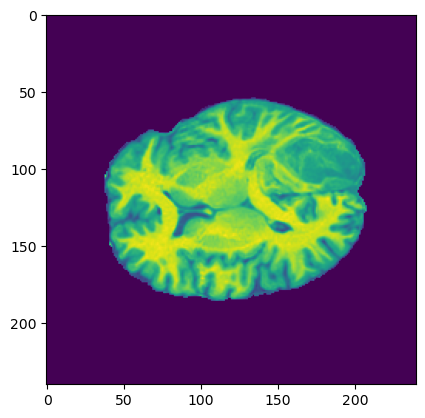

In [58]:
plt.imshow(t1[:,:,80])

In [59]:
t2 =  nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_t2.nii.gz')).get_fdata()

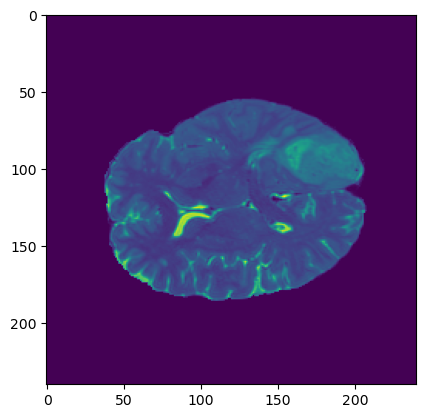

In [60]:
plt.imshow(t2[:,:,80])

In [61]:
t1ce =  nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_t1ce.nii.gz')).get_fdata()

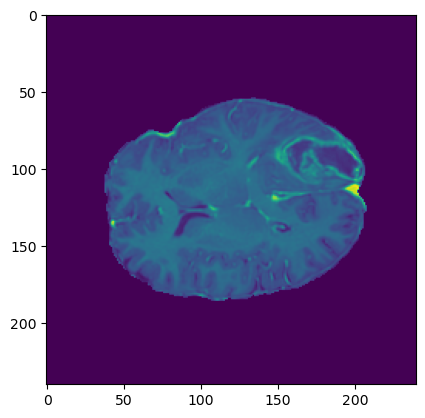

In [62]:
plt.imshow(t1ce[:,:,80])

In [66]:
seg = nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_seg.nii.gz')).get_fdata()

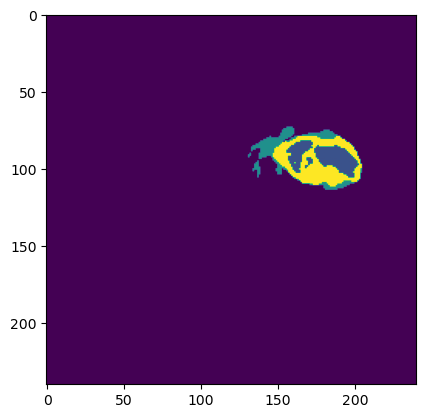

In [67]:
plt.imshow(seg[:,:,80])

4/4 [==============================] - 1s 280ms/step


<Figure size 640x480 with 0 Axes>

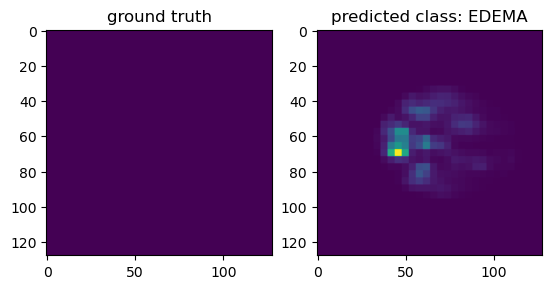

In [114]:
case = test_ids[11][-6:]
path = f"/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data/BraTS2021{case}"
gt =  nib.load(os.path.join(path, f'BraTS2021{case}_seg.nii.gz')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt)
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class])
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [121]:
 X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
 
flair= nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_flair.nii.gz')).get_fdata()
ce= nib.load(('/Users/sanjaydilli/Downloads/archive/BraTS2021_00495/BraTS2021_00495_t1ce.nii.gz')).get_fdata()
for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 

In [126]:
X.shape

(128, 128, 128, 2)

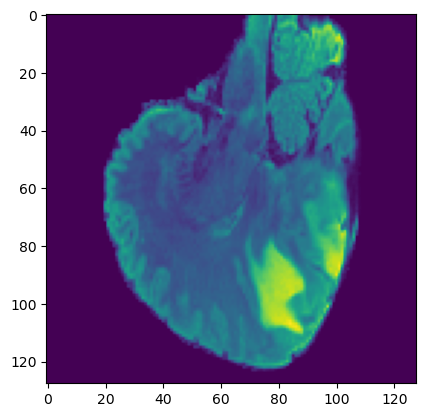

In [132]:
plt.imshow(X[:,60,:,0])